In [1]:
import os
import numpy as np
from scipy.signal import butter, lfilter
import csv
import matplotlib.pyplot as plt
from scipy.signal import detrend

In [2]:
fs = 256.0

In [3]:
def lowpass(sig, fc, fs, butter_filt_order=4):
    B, A = butter(butter_filt_order, np.array(fc)/(fs/2), btype='low')
    return lfilter(B, A, sig, axis=0)

In [4]:
def decode_stim(data_path, file_stim):
    interval_corrupt = []
    blinks = []
    n_corrupt = 0
    with open(os.path.join(data_path, file_stim)) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            if row[0] == "corrupt":
                n_corrupt = int(row[1])
            elif n_corrupt > 0:
                interval_corrupt.append([float(row[0]), float(row[1]) if float(row[1]) != -1 else np.inf])
                n_corrupt -= 1
            elif row[0] == "blinks":
                continue
            else:
                blinks.append([float(row[0]), 1])
    return interval_corrupt, np.array(blinks)

In [5]:
def preprocess_data_and_labels(data_sig, groundtruth_blinks, last_timestamp, cumulative_samples, fs):
    if last_timestamp > 0:
        adjustment = last_timestamp + (1 / fs) - data_sig[0, 0]
        data_sig[:, 0] += adjustment
    else:
        adjustment = 0
    
    data_sig[:, 1] = lowpass(data_sig[:, 1], 10, fs, 4)  #channel1
    data_sig[:, 2] = lowpass(data_sig[:, 2], 10, fs, 4)  #channel2
    
    blink_sample_nums = []
    for blink_time, _ in groundtruth_blinks:
        adjusted_blink_time = blink_time + adjustment
        #the closest sample in the EEG data to the adjusted blink time
        closest_sample_index = np.argmin(np.abs(data_sig[:, 0] - adjusted_blink_time))
        blink_sample_nums.append(closest_sample_index + cumulative_samples)
    
    last_timestamp = data_sig[-1, 0]
    cumulative_samples += len(data_sig)
    
    return data_sig, np.array(blink_sample_nums), last_timestamp, cumulative_samples

In [6]:
data_folder = 'path_to_data'

all_data = []
all_blink_sample_nums = []
last_timestamp = 0
cumulative_samples = 0

In [7]:
for file in sorted(os.listdir(data_folder)):
    if '_data' in file:
        file_path = os.path.join(data_folder, file)
        file_stim = file_path.replace('_data', '_labels')

        data_sig = np.loadtxt(file_path, delimiter=";", skiprows=1, usecols=(0, 1, 2))
        
        _, groundtruth_blinks = decode_stim(data_folder, file_stim)
        
        processed_data, blink_sample_nums, last_timestamp, cumulative_samples = preprocess_data_and_labels(
            data_sig, groundtruth_blinks, last_timestamp, cumulative_samples, fs)
        
        all_data.append(processed_data)
        all_blink_sample_nums.extend(blink_sample_nums)

In [8]:
all_data = np.concatenate(all_data, axis=0)

In [9]:
#data in shape (timestamp, channel1, channel2)
all_data.shape

(505792, 3)

In [10]:
#samples where minimum value of blinking event is occured
print(all_blink_sample_nums)

[1105, 2170, 3118, 4083, 5088, 6120, 7210, 8063, 9063, 10093, 11110, 12080, 13108, 14120, 15125, 16055, 17085, 18105, 19075, 20080, 21085, 22085, 23063, 24088, 25113, 25841, 26651, 27658, 28653, 29621, 30661, 31673, 32661, 33623, 34646, 35628, 36661, 37663, 38648, 39663, 40643, 41653, 42648, 43638, 44693, 45698, 46663, 47653, 48648, 49658, 50713, 52241, 53241, 54214, 55216, 56211, 57249, 58261, 59241, 60201, 61259, 62221, 63211, 64234, 65234, 66221, 67236, 68229, 69256, 70246, 71209, 72221, 73201, 74221, 75201, 76206, 77834, 78807, 79829, 80812, 81892, 82912, 83927, 84899, 85904, 86964, 87972, 88964, 89867, 91007, 91859, 92557, 92812, 93854, 94387, 94902, 95889, 96887, 97927, 98887, 100919, 101939, 103362, 104372, 105352, 106415, 107420, 108385, 109382, 110427, 111480, 112410, 113307, 114327, 115375, 116347, 117370, 118307, 119322, 120352, 121322, 122332, 123427, 124120, 124520, 125390, 126417, 127422, 128888, 129943, 130951, 131946, 132951, 134013, 134948, 135951, 136931, 137948, 1389

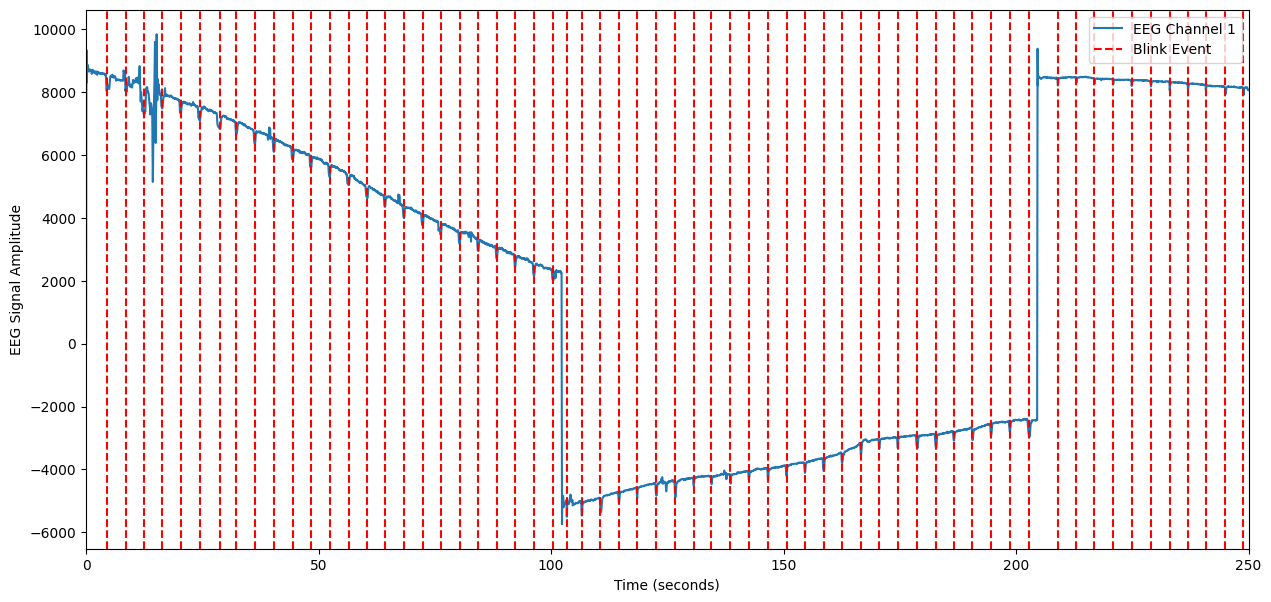

In [11]:
end_index = np.where(all_data[:, 0] <= 250)[0][-1]

plt.figure(figsize=(15, 7))
plt.plot(all_data[:end_index, 0], all_data[:end_index, 1], label='EEG Channel 1')

for blink_sample_num in all_blink_sample_nums[:-1]:
    if blink_sample_num <= end_index:
        blink_timestamp = all_data[blink_sample_num, 0]
        plt.axvline(x=blink_timestamp, color='r', linestyle='--', label='Blink Event' if plt.gca().get_legend_handles_labels()[1].count('Blink Event') == 0 else "")

plt.xlabel('Time (seconds)')
plt.ylabel('EEG Signal Amplitude')
plt.xlim(0, 250)  #limit to 250s for clarity
plt.legend()
plt.show()

<b>Random Forest classifier</b>

In [12]:
window_ms = 400
window_samples = int(fs * (window_ms / 1000.0) / 2)

X = []
y = []
event_indexes = []

#blinking events
for blink_sample_num in all_blink_sample_nums:
    start_index = blink_sample_num - window_samples
    end_index = blink_sample_num + window_samples
    if start_index >= 0 and end_index < len(all_data):
        blink_event = detrend(all_data[start_index:end_index, 1])  #channel 1
        X.append(blink_event)
        y.append(1)
        event_indexes.append((start_index, end_index))

#non-blinking events
for i in range(len(all_blink_sample_nums) - 1):
    current_end = all_blink_sample_nums[i] + window_samples
    next_start = all_blink_sample_nums[i + 1] - window_samples
    
    if next_start > current_end:
        mid_point = (current_end + next_start) // 2
        start_index = mid_point - window_samples
        end_index = mid_point + window_samples
        
        if start_index >= 0 and end_index < len(all_data):
            non_blink_event = detrend(all_data[start_index:end_index, 1])  #channel 1
            X.append(non_blink_event)
            y.append(0)
            event_indexes.append((start_index, end_index))

X = np.array(X)
y = np.array(y)


In [13]:
X.shape

(1112, 102)

In [14]:
y.shape

(1112,)

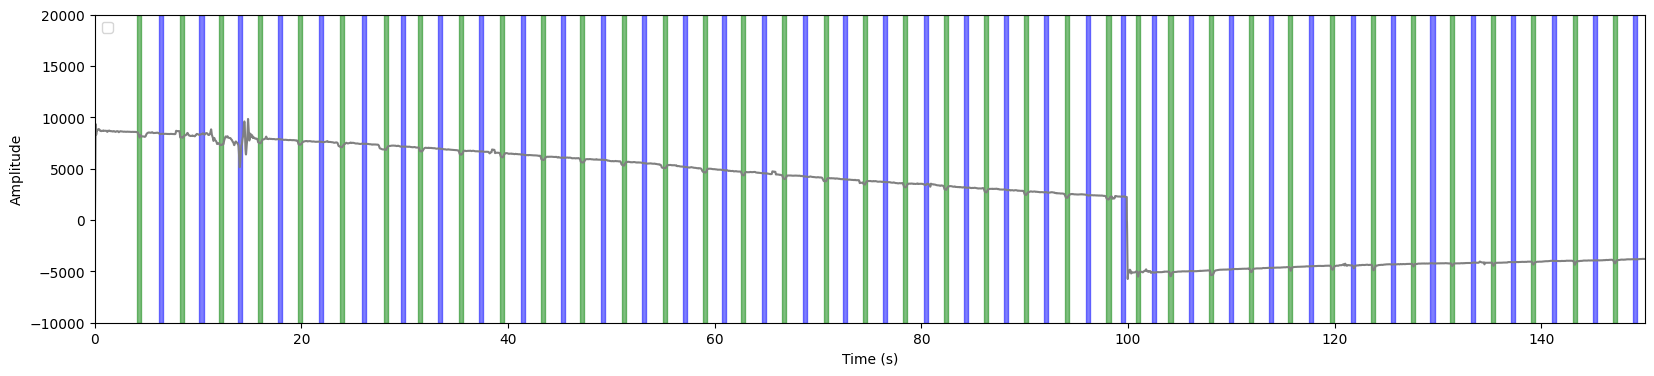

In [15]:
import matplotlib.pyplot as plt
import numpy as np

continuous_eeg_signal = all_data[:, 1]
time_vector = np.arange(len(continuous_eeg_signal)) / fs

plt.figure(figsize=(20, 4))
plt.plot(time_vector, continuous_eeg_signal, color='gray')

for i, (start_index, end_index) in enumerate(event_indexes):
    event_time_start = start_index / fs
    event_time_end = end_index / fs
    label = y[i]

    if event_time_start <= 150:
        color = 'green' if label == 1 else 'blue'

        event_time_end = min(event_time_end, 150)
        plt.axvspan(event_time_start, event_time_end, color=color, alpha=0.5)

plt.xlim(0, 150)
plt.ylim(-10000, 20000) 
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#train
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

#evaluation: test set
y_test_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy}')
print(classification_report(y_test, y_test_pred))

# joblib.dump(clf, "random_forest_eeg_classifier.pkl")

Test Accuracy: 0.9506726457399103
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       103
           1       0.98      0.93      0.95       120

    accuracy                           0.95       223
   macro avg       0.95      0.95      0.95       223
weighted avg       0.95      0.95      0.95       223

